In [2]:
from prismo import PRISMO
import matplotlib.pyplot as plt
import numpy as np
from plotnine import *
import pandas as pd

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [3]:
models_multi_group = []
models_single_group = []

for i in range(10):
    models_multi_group.append(PRISMO.load(f"models/multi_group_{i}.h5"))
    models_single_group.append(PRISMO.load(f"models/single_group_{i}.h5"))

In [4]:
df_list = []

for i in range(len(models_single_group)):
    df = pd.DataFrame(
        {
            "pathway" : models_single_group[i].factor_names,
            "model" : str(i),
        }
    )
    df = df[~df["pathway"].str.startswith("Factor")]
    df.set_index("pathway", inplace=True)
    df["x_mg"] = models_multi_group[i].get_r2()["group_xenium"]["rna"]
    df["x_sg"] = models_single_group[i].get_r2()["group_xenium"]["rna"]
    df["c_mg"] = models_multi_group[i].get_r2()["group_chromium"]["rna"]
    df["x_mg_rank"] = df["x_mg"].rank(method="first", ascending=False).astype(int) - 1
    df["x_sg_rank"] = df["x_sg"].rank(method="first", ascending=False).astype(int) - 1
    df["c_mg_rank"] = df["c_mg"].rank(method="first", ascending=False).astype(int) - 1
    df_list.append(df)

df = pd.concat(df_list)

df.reset_index(inplace=True)
df["pathway"] = df["pathway"].str.replace("HALLMARK_", "").str.replace("_", " ").str.title()

df = df.groupby("pathway").agg(
    mean_x_mg=("x_mg", "mean"),
    std_x_mg=("x_mg", "std"),
    mean_x_sg=("x_sg", "mean"),
    std_x_sg=("x_sg", "std"),
    mean_c_mg=("c_mg", "mean"),
    std_c_mg=("c_mg", "std"),
    mean_x_mg_rank=("x_mg_rank", "mean"),
    std_x_mg_rank=("x_mg_rank", "std"),
    mean_x_sg_rank=("x_sg_rank", "mean"),
    std_x_sg_rank=("x_sg_rank", "std"),
    mean_c_mg_rank=("c_mg_rank", "mean"),
    std_c_mg_rank=("c_mg_rank", "std"),
)

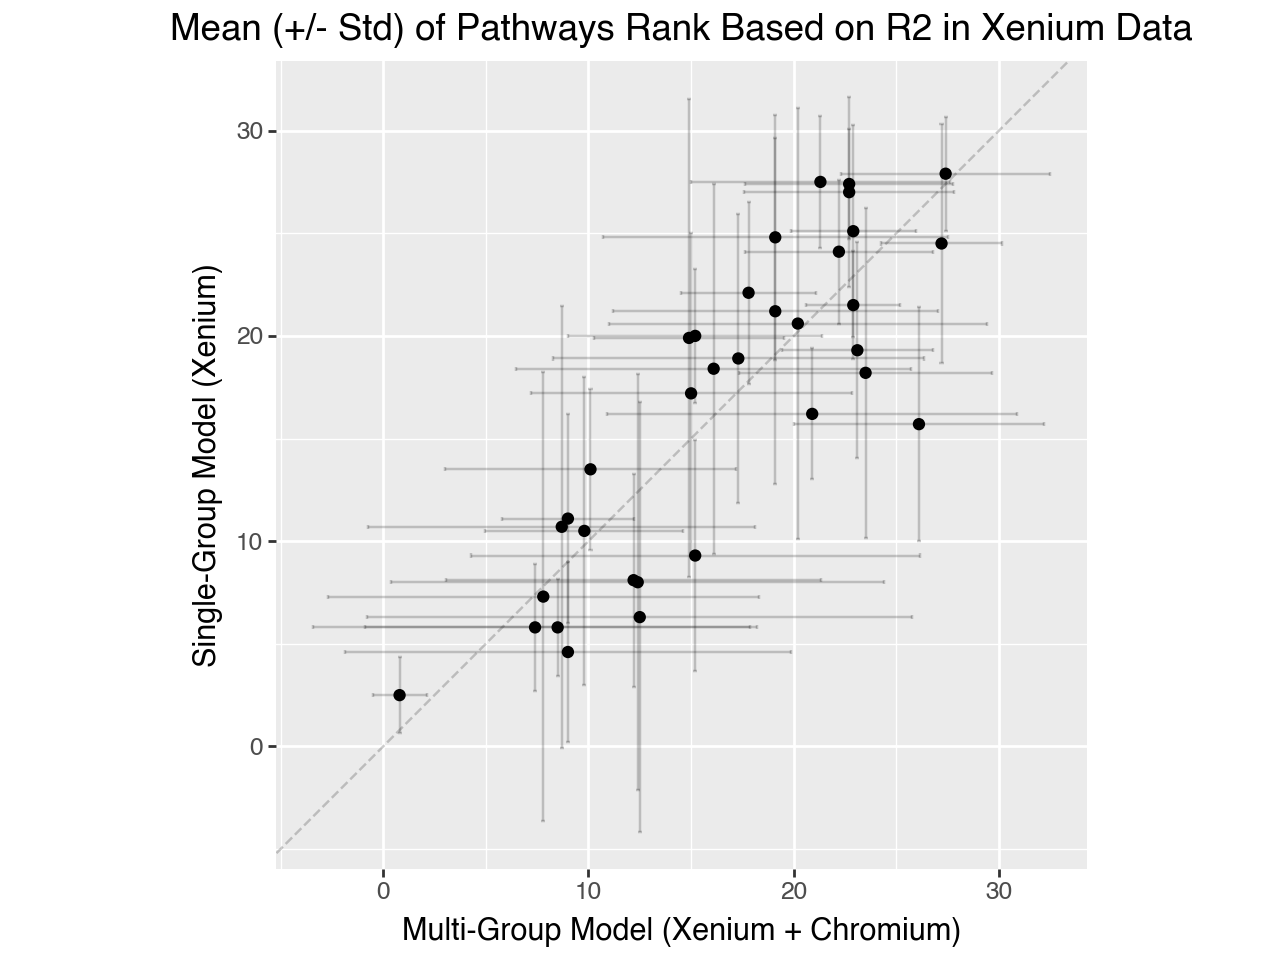

In [5]:
plot = (
    ggplot(df, aes(x="mean_x_mg_rank", y="mean_x_sg_rank"))
    + geom_point()
    + geom_errorbar(aes(ymin="mean_x_sg_rank - std_x_sg_rank", ymax="mean_x_sg_rank + std_x_sg_rank"), width=0.2, alpha=0.2)
    + geom_errorbarh(aes(xmin="mean_x_mg_rank - std_x_mg_rank", xmax="mean_x_mg_rank + std_x_mg_rank"), height=0.2, alpha=0.2)
    + coord_fixed(ratio=1)
    + labs(title="Mean (+/- Std) of Pathways Rank Based on R2 in Xenium Data", x="Multi-Group Model (Xenium + Chromium)", y="Single-Group Model (Xenium)")
    + geom_abline(intercept=0, slope=1, linetype="dashed", alpha=0.2)
)
plot.show()

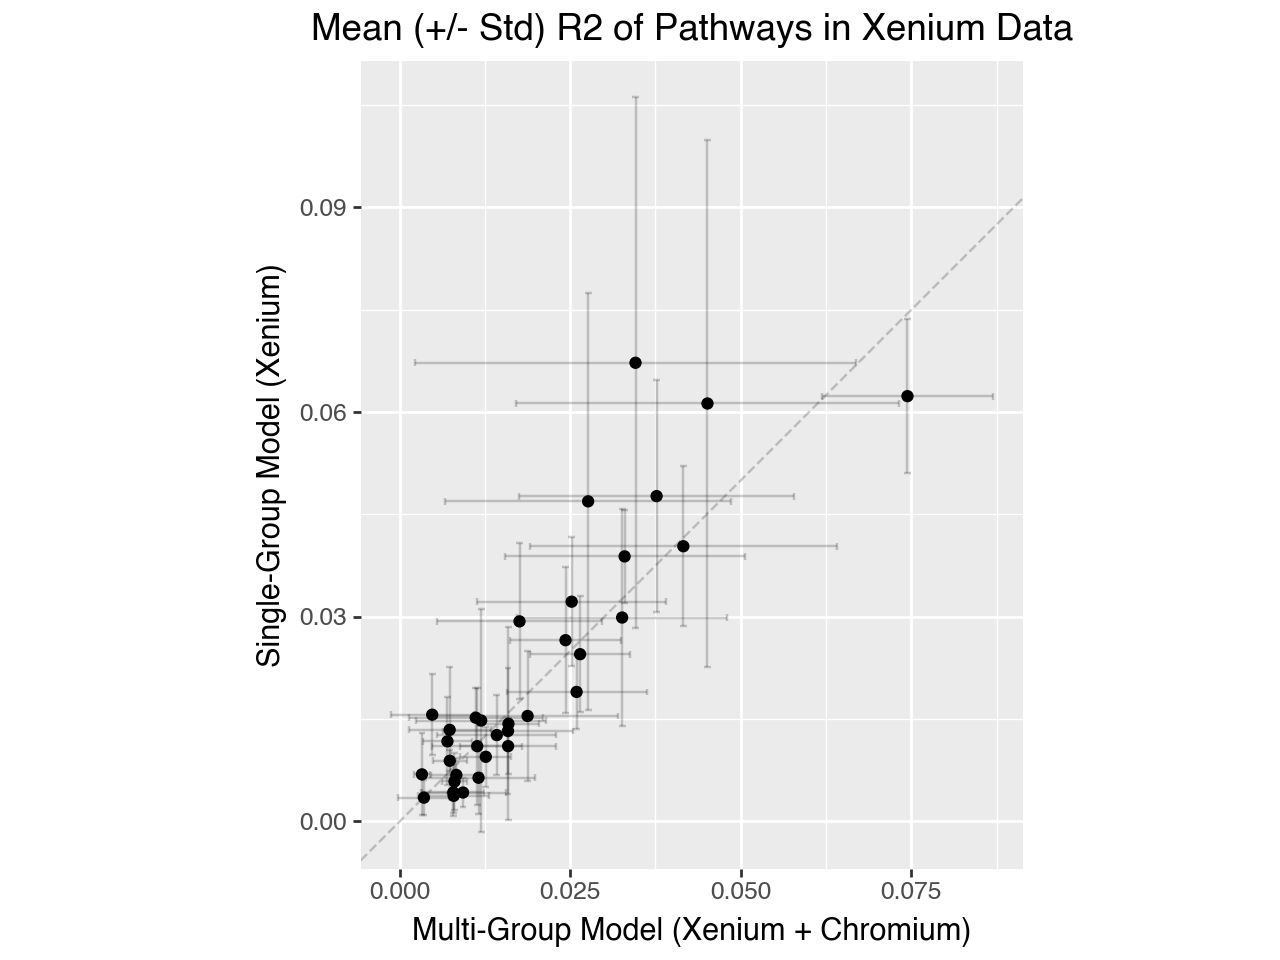

In [6]:
plot = (
    ggplot(df, aes(x="mean_x_mg", y="mean_x_sg"))
    + geom_point()
    + geom_errorbar(aes(ymin="mean_x_sg - std_x_sg", ymax="mean_x_sg + std_x_sg"), width=0.001, alpha=0.2)
    + geom_errorbarh(aes(xmin="mean_x_mg - std_x_mg", xmax="mean_x_mg + std_x_mg"), height=0.001, alpha=0.2)
    + coord_fixed(ratio=1)
    + labs(title="Mean (+/- Std) R2 of Pathways in Xenium Data", x="Multi-Group Model (Xenium + Chromium)", y="Single-Group Model (Xenium)")
    + geom_abline(intercept=0, slope=1, linetype="dashed", alpha=0.2)
)
plot.show()

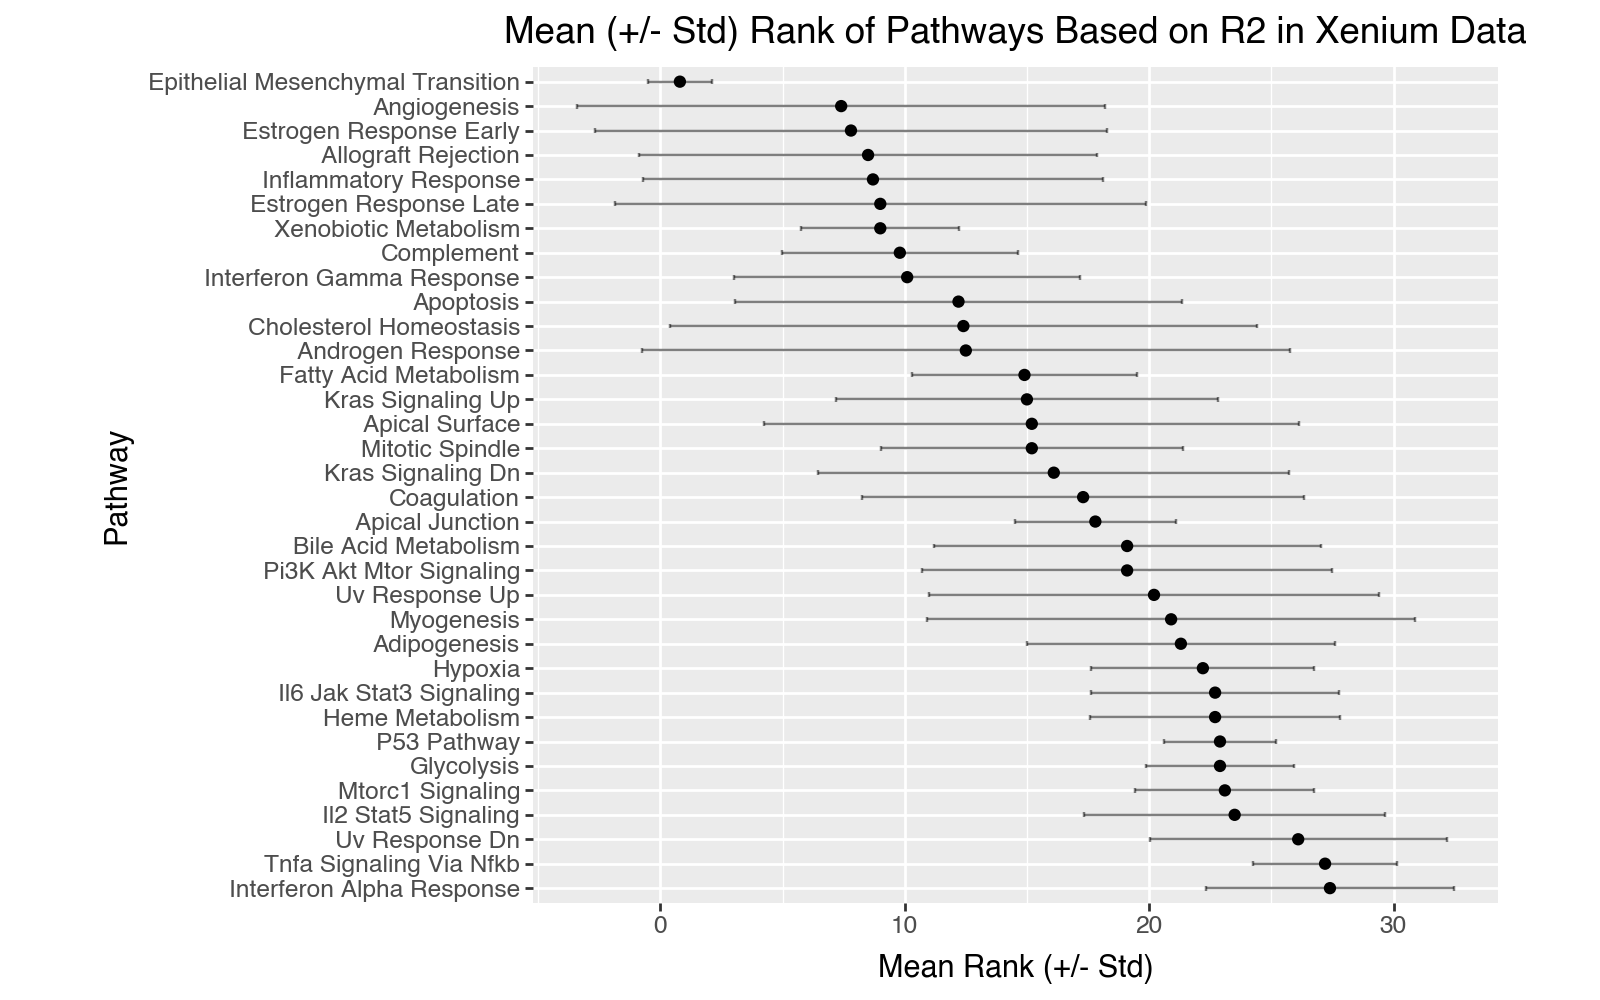

In [7]:
df_sorted = df.copy().reset_index().sort_values("mean_x_mg_rank", ascending=False)
df_sorted["pathway"] = pd.Categorical(df_sorted["pathway"], categories=df_sorted["pathway"], ordered=True)

plot = (
    ggplot(df_sorted, aes(x="mean_x_mg_rank", y="pathway"))
    + geom_errorbarh(aes(xmin="mean_x_mg_rank - std_x_mg_rank", xmax="mean_x_mg_rank + std_x_mg_rank"), height=0.2, alpha=0.5)
    + geom_point()
    + labs(title="Mean (+/- Std) Rank of Pathways Based on R2 in Xenium Data", x="Mean Rank (+/- Std)", y="Pathway")
    + coord_equal()
    + theme(figure_size=(8, 5))
)

plot.show()

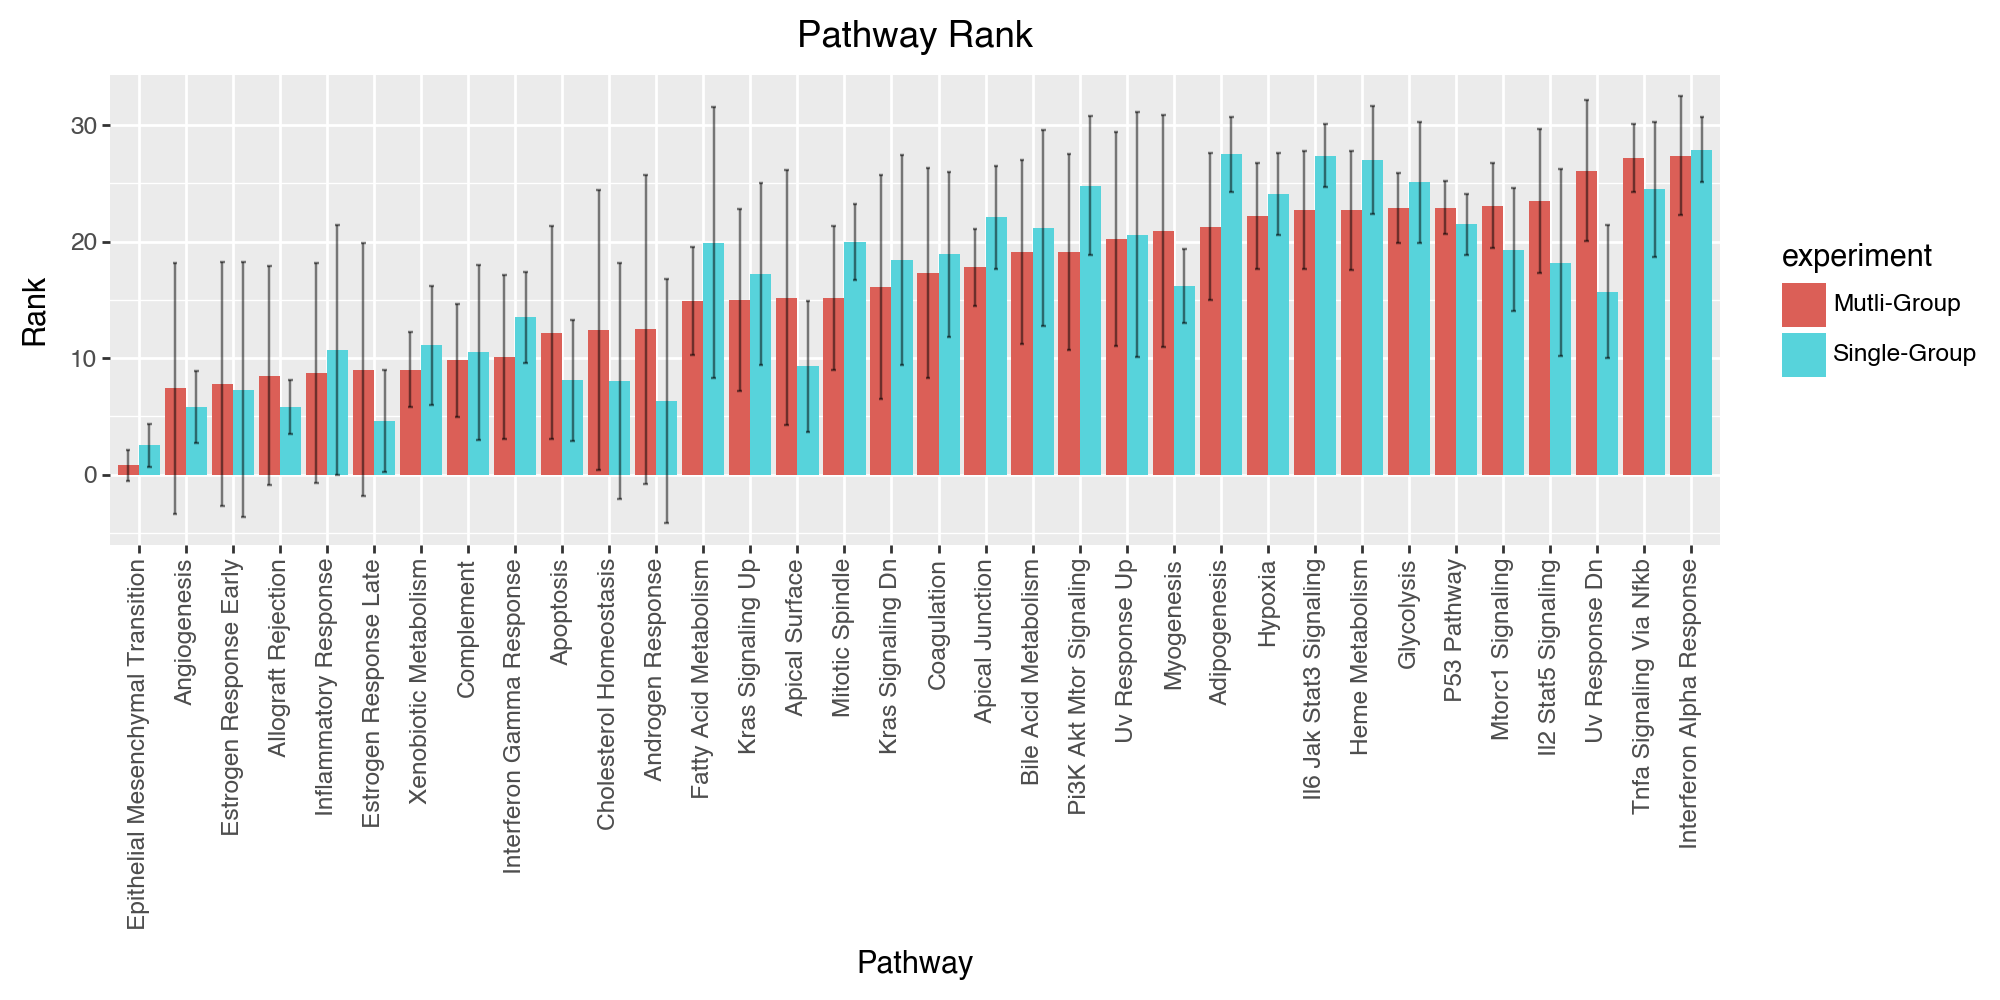

In [8]:
df_long = pd.melt(df.reset_index(), id_vars="pathway", value_vars=["mean_x_mg_rank", "mean_x_sg_rank"], var_name="experiment", value_name="mean")
df_long["std"] = pd.melt(df.reset_index(), id_vars="pathway", value_vars=["std_x_mg_rank", "std_x_sg_rank"], var_name="experiment", value_name="std")["std"]

pathway_order = df.sort_values("mean_x_mg_rank").index
df_long["pathway"] = pd.Categorical(df_long["pathway"], categories=pathway_order, ordered=True)

df_long.replace({"mean_x_mg_rank" : "Mutli-Group", "mean_x_sg_rank" : "Single-Group"}, inplace=True)

plot = (
    ggplot(df_long, aes(x="pathway", y="mean", fill="experiment"))
    + geom_bar(stat="identity", position="dodge")
    + theme(axis_text_x=element_text(rotation=90, hjust="center"), figure_size=(10, 5))
    + labs(x="Pathway", y="Rank", title="Pathway Rank")
    + geom_errorbar(aes(ymin="mean - std", ymax="mean + std"), width=0.2, position=position_dodge(width=0.9), alpha=0.5)
)
plot.show()

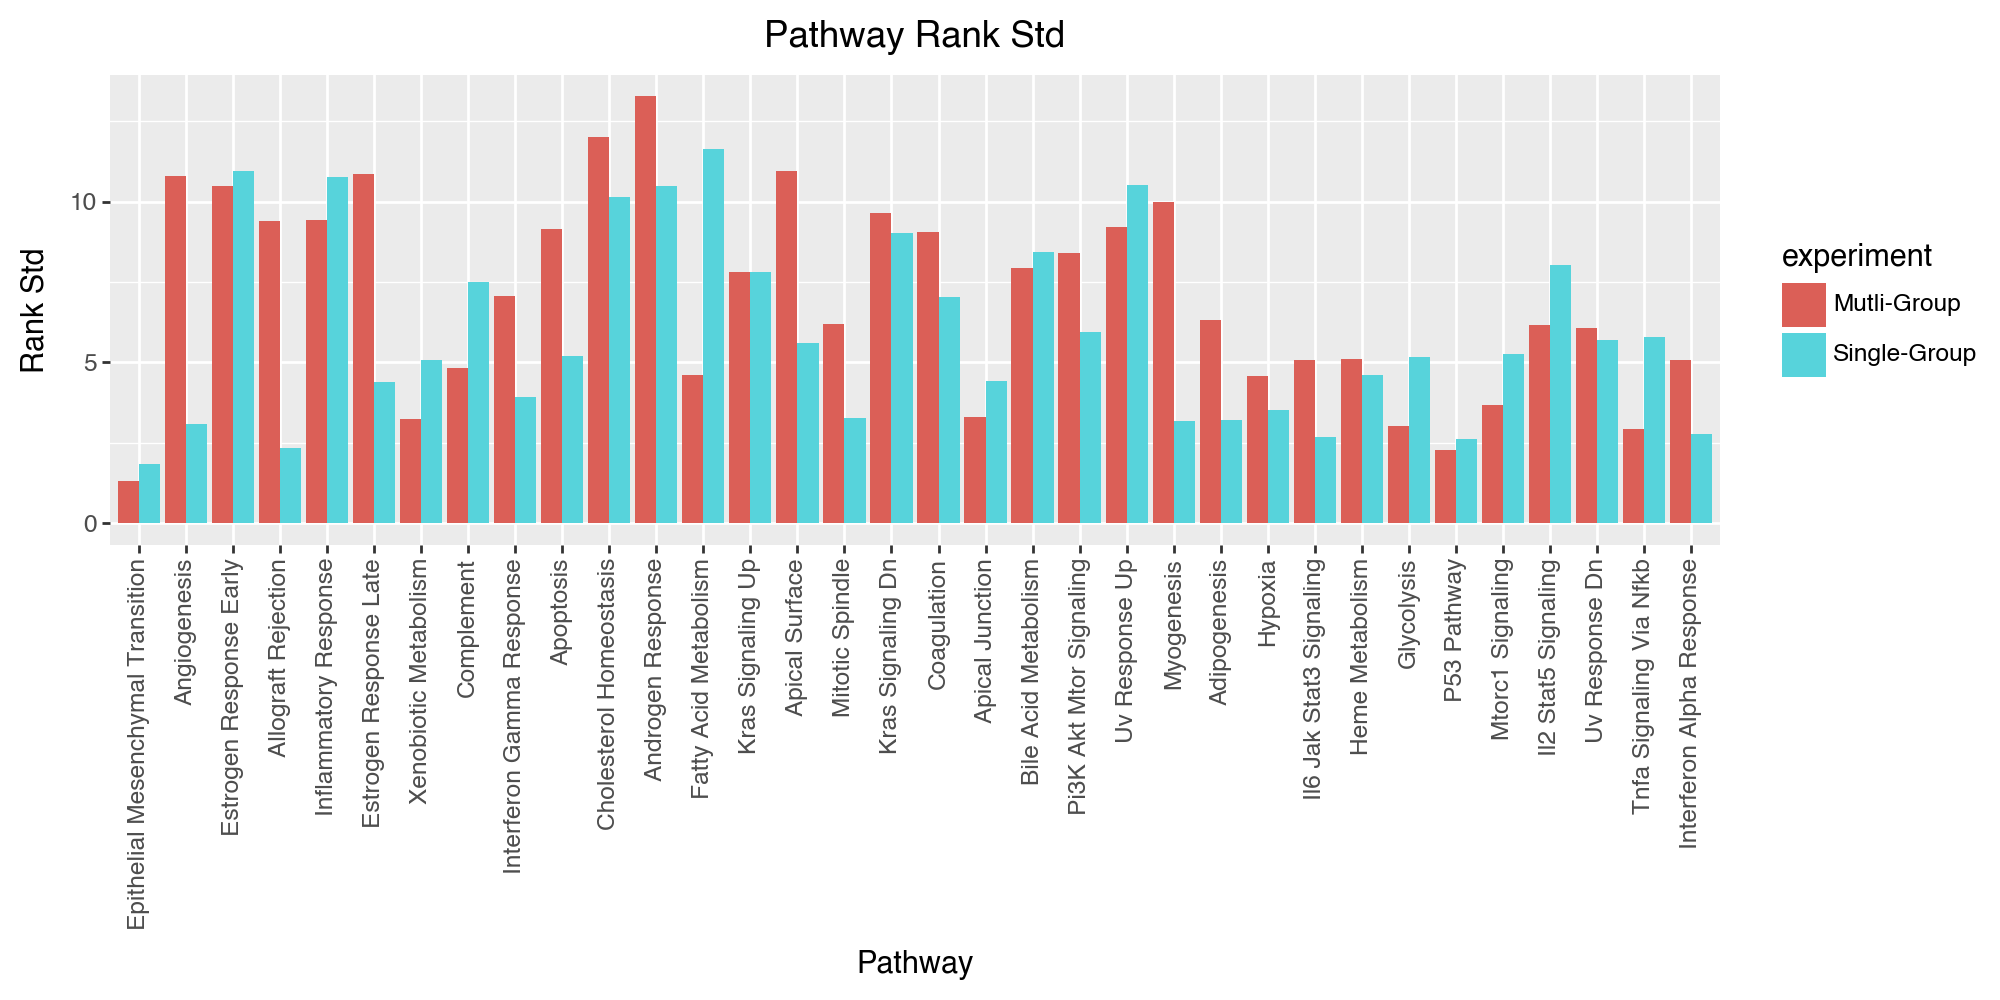

In [9]:
plot = (
    ggplot(df_long, aes(x="pathway", y="std", fill="experiment"))
    + geom_bar(stat="identity", position="dodge")
    + theme(axis_text_x=element_text(rotation=90, hjust="center"), figure_size=(10, 5))
    + labs(x="Pathway", y="Rank Std", title="Pathway Rank Std")
)
plot.show()

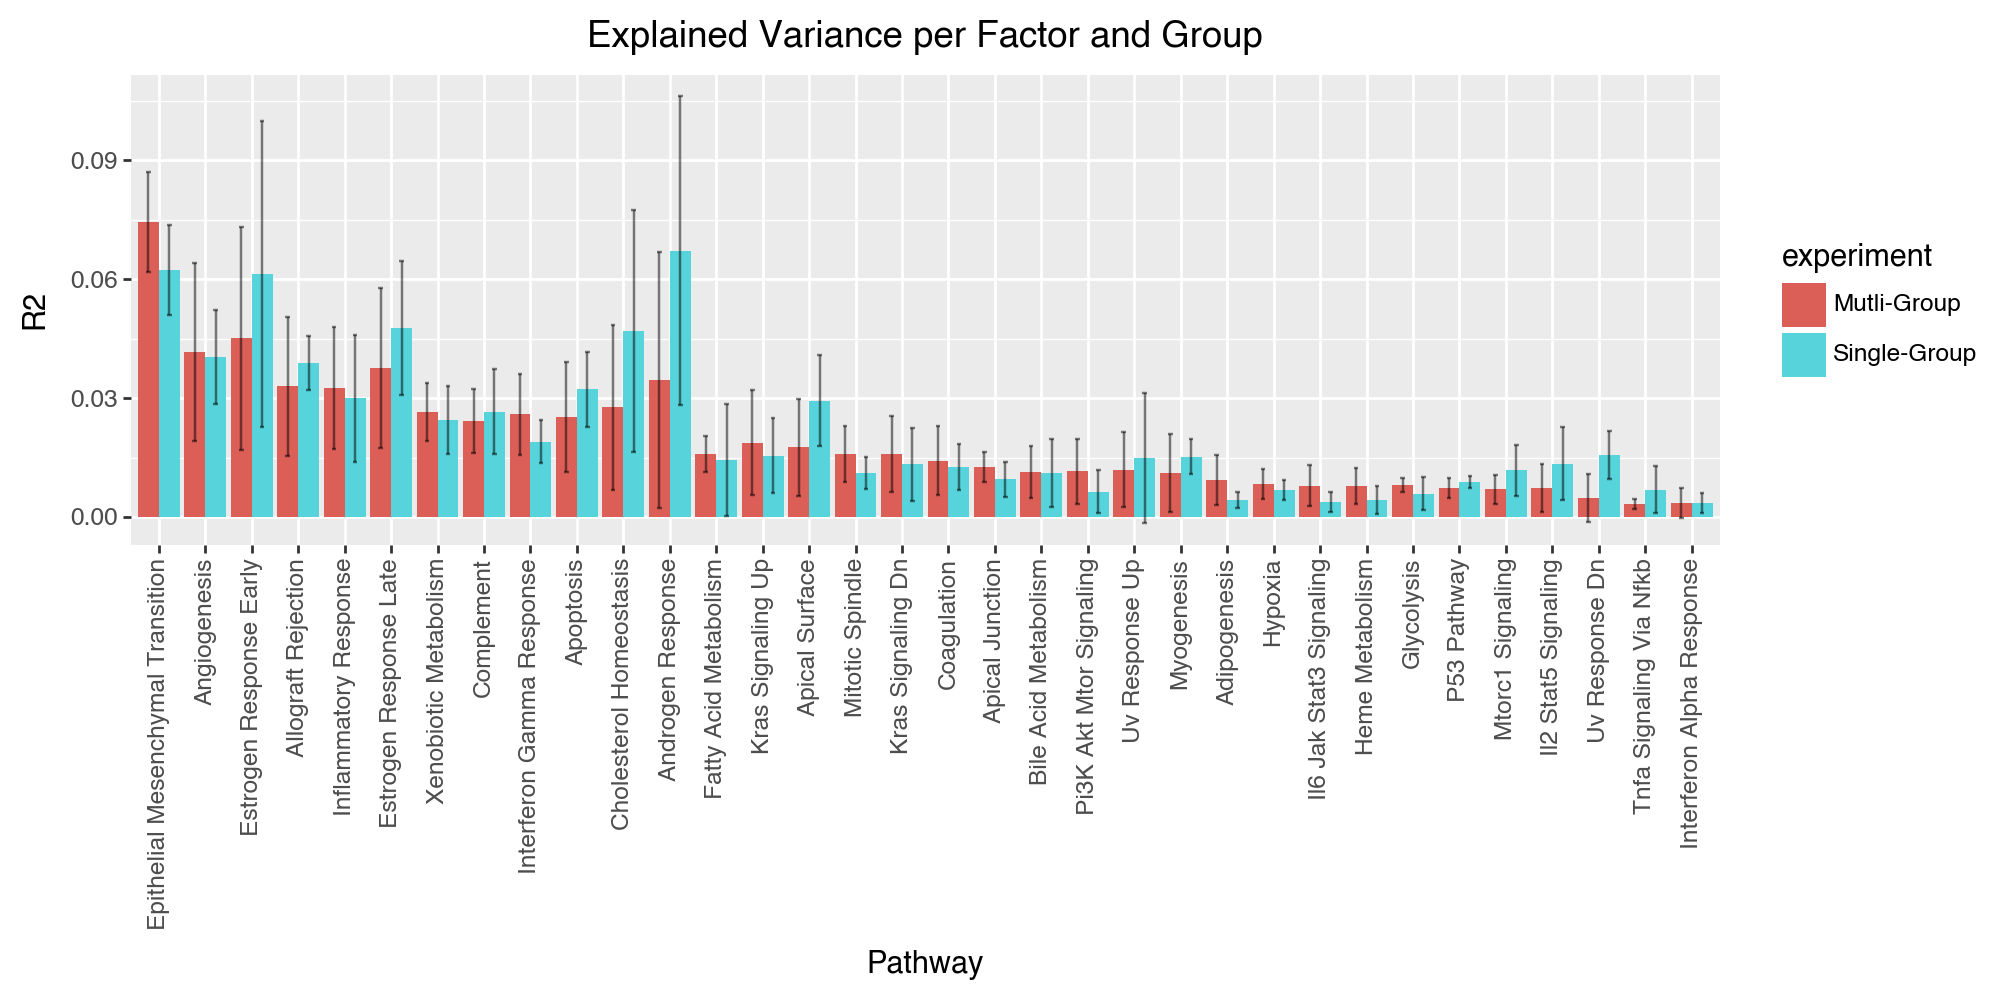

In [10]:
df_long = pd.melt(df.reset_index(), id_vars="pathway", value_vars=["mean_x_mg", "mean_x_sg"], var_name="experiment", value_name="mean")
df_long["std"] = pd.melt(df.reset_index(), id_vars="pathway", value_vars=["std_x_mg", "std_x_sg"], var_name="experiment", value_name="std")["std"]

pathway_order = df.sort_values("mean_x_mg_rank").index
df_long["pathway"] = pd.Categorical(df_long["pathway"], categories=pathway_order, ordered=True)

df_long.replace({"mean_x_mg" : "Mutli-Group", "mean_x_sg" : "Single-Group"}, inplace=True)

plot = (
    ggplot(df_long, aes(x="pathway", y="mean", fill="experiment"))
    + geom_bar(stat="identity", position="dodge")
    + theme(axis_text_x=element_text(rotation=90, hjust="center"), figure_size=(10, 5))
    + labs(x="Pathway", y="R2", title="Explained Variance per Factor and Group")
    + geom_errorbar(aes(ymin="mean - std", ymax="mean + std"), width=0.2, position=position_dodge(width=0.9), alpha=0.5)
)
plot.show()